In [84]:
import argparse
import os
import pickle

import torch
import torch.nn.functional as F
import torchvision.utils as vutils
import numpy as np
import matplotlib.gridspec as gridspec
from kmeans_pytorch import kmeans
from matplotlib import pyplot as plt
from matplotlib.cm import get_cmap
from rtpt import RTPT
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from torch.nn import DataParallel as DP
from torch.utils.data import DataLoader
from torchvision.transforms.functional import rgb_to_grayscale
from tqdm import tqdm

from sysbinder.data import GlobDataset
from data import CLEVREasyWithAnnotations
from sysbinder.sysbinder import SysBinderImageAutoEncoder
from sysbinder.utils import set_seed
from retrievalbinder import NeuralConceptBinder, NonLinClassifier
import utils_bnr as utils_bnr


class Args:
    seed = 0
    batch_size = 1
    num_workers = 4
    image_size = 128
    image_channels = 3

    checkpoint_path = "logs/sysbind_orig_seed0/best_model.pt"
#     checkpoint_path = "logs/sysbind_hard_seed0/best_model.pt"
#     checkpoint_path = "logs/sysbind_step_seed0/best_model.pt"
#     data_path = "/Users/ml-wstammer/Documents/PhD/datasets/clevr-easy-1-small/"
#     data_path = "/Users/ml-wstammer/Documents/PhD/datasets/clevr-easy/**/*.png"
    data_path = "/Users/ml-wstammer/Documents/PhD/datasets/CLEVR-Easy-1/"
    log_path = "logs/"

    lr_dvae = 3e-4
    lr_enc = 1e-4
    lr_dec = 3e-4
    lr_warmup_steps = 30000
    lr_half_life = 250000
    clip = 0.05
    epochs = 1 
    num_iterations = 3
    num_slots = 4
    num_blocks = 8
    cnn_hidden_size = 512
    slot_size = 2048
    mlp_hidden_size = 192
    num_prototypes = 64
    temp = 1.
    temp_step = False
    binarize = False

    vocab_size = 4096
    num_decoder_layers = 8
    num_decoder_heads = 4
    d_model = 192
    dropout = 0.1

    tau_start = 1.0
    tau_final = 0.1
    tau_steps = 30000

    use_dp = False

    # arguments for clustering
    cluster_type = 'kmeans'
    num_clusters = 12
    num_show_per_cluster = 20

args=Args()
args.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_seed(args.seed)

args.log_dir = os.path.join(*args.checkpoint_path.split(os.path.sep)[:-1])

# set seed
torch.manual_seed(args.seed)

In [85]:
# get all train data
if '-1' in args.data_path:
    train_dataset = CLEVREasyWithAnnotations(
        root=args.data_path, phase="train", img_size=args.image_size, max_num_objs=args.num_slots,
        label_type="dt", num_categories=2,
    )
    test_dataset = CLEVREasyWithAnnotations(
        root=args.data_path, phase="test", img_size=args.image_size, max_num_objs=args.num_slots,
        label_type="dt", num_categories=2,
    )

    loader_kwargs = {
        "batch_size": args.batch_size,
        "shuffle": True,
        "num_workers": args.num_workers,
        "pin_memory": True,
        "drop_last": True,
    }
    train_loader = DataLoader(train_dataset, **loader_kwargs)
    loader_kwargs = {
        "batch_size": args.batch_size,
        "shuffle": False,
        "num_workers": args.num_workers,
        "pin_memory": True,
        "drop_last": True,
    }
    test_loader = DataLoader(test_dataset, **loader_kwargs)
elif 'clevr-easy/' in args.data_path:
    train_dataset = GlobDataset(root=args.data_path, phase='train', img_size=args.image_size)
    val_dataset = GlobDataset(root=args.data_path, phase='val', img_size=args.image_size)

    train_sampler = None
    val_sampler = None

    loader_kwargs = {
        'batch_size': args.batch_size,
        'shuffle': True,
        'num_workers': args.num_workers,
        'pin_memory': True,
        'drop_last': True,
    }

    train_loader = DataLoader(train_dataset, sampler=train_sampler, **loader_kwargs)
    val_loader = DataLoader(val_dataset, sampler=val_sampler, **loader_kwargs)

# load model (from checkpoint)    
model = SysBinderImageAutoEncoder(args)

if os.path.isfile(args.checkpoint_path):
    checkpoint = torch.load(args.checkpoint_path, map_location="cpu")
    model.load_state_dict(checkpoint)
    args.log_dir = os.path.join(*args.checkpoint_path.split(os.path.sep)[:-1])
    print("Model loaded.")
else:
    print("Model path was not found.")

model = model.to(args.device)
if args.use_dp:
    model = DP(model)

model.eval()
print("")

Model loaded.



In [81]:
def get_next_sample_and_encs(model, loader, args):
    sample = next(iter(loader))

    if '-1' in args.data_path:
        imgs, _, annotations, _, class_labels, _ = map(lambda x: x.to(args.device), sample)
    elif 'clevr-easy/' in args.data_path:
        imgs = sample.to(args.device)

        
    # encode image 
    encs = model.encode(imgs)

    assert imgs.shape[0] == 1 
    assert encs[0].shape[0] == 1

    img = imgs[0]
    slots = encs[0][0].detach().cpu().numpy()
    attns_vis = encs[1][0].detach().cpu().numpy()
    attns = encs[2][0].detach().cpu().numpy()
    
    return img, slots, attns_vis, attns


def plot_img_and_attns(img, attns_vis, attns):
    fig, axs = plt.subplots(2, 3)
    axs = axs.flatten()
    axs[0].imshow(np.transpose(img, (1, 2, 0)))
    axs[0].axis('off')
    for i in range(0, 4):
        axs[i+1].imshow(np.transpose(attns[i], (1, 2, 0)))
        axs[i+1].axis('off')
    axs[-1].axis('off')
        

def plot_hists(attns):
    n_bins = 50
    cmap = get_cmap('tab10')  # type: matplotlib.colors.ListedColormap
    colors = cmap.colors
    
    fig, ax = plt.subplots(1, 1, figsize=(5,2))
    for i in range(0, 4):
        ax.hist(attns[i].flatten(), n_bins)
    ax.legend([0, 1, 2, 3])
    ax.set_ylim([0, 2000])
    ax.set_xlim([0, 1])

    fig, ax = plt.subplots(2, 2, figsize=(10, 5))
    ax = ax.flatten()
    for i in range(0, 4):
        h = ax[i].hist(attns[i].flatten(), n_bins, color=colors[i])
        ax[i].set_ylim([0, 2000])
        ax[i].set_title(f'slot {i}')
        ax[i].set_xlim([0, 1])
        
        
def plot_single_img(torch_img, title):
    assert torch_img.shape[0] == 1
    img = torch_img[0].detach().cpu().numpy()
    
    fig, ax = plt.subplots(1, 1, figsize=(2,2))
    ax.imshow(np.transpose(img, (1, 2, 0)))
    ax.axis('off')
    ax.set_title(title)

    
def plot_tuple_np_img(np_img_tuple, block_id):
    '''
    Expects a tuple of numpy array imgs, where the dims are already [w, h, c].
    '''
    assert len(np_img_tuple[0].shape) == 3 and len(np_img_tuple[1].shape) == 3 
    img1 = np_img_tuple[0]
    img2 = np_img_tuple[1]
    
    fig, axs = plt.subplots(1, 2, figsize=(4, 7))
    axs[0].imshow(img1)
    axs[0].axis('off')
    axs[0].set_title('orig')
    axs[1].imshow(img2)
    axs[1].axis('off')
    axs[1].set_title(f'swapped: {block_id}')
    

def plot_all_tuple_np_imgs(tuple_np_imgs, args):
    '''
    Takes the list of tuples, where one tuple at list position i contains the decoded original output at position 0
    and the decoded output of the swapped slot representation at position 1. The function then plots a grid of 
    subplots where each subplot contains the original image on the left and the swapped image on the right.
    '''
    fig = plt.figure(figsize=(8, 6))
    assert args.num_blocks == 8 # otherwise update grid dimensions
    outer = gridspec.GridSpec(4, 2, wspace=0.2, hspace=0.3)

    for i in range(args.num_blocks):
        inner = gridspec.GridSpecFromSubplotSpec(1, 2,
                        subplot_spec=outer[i], wspace=0.1, hspace=0.1)

        for j in range(2):
            ax = plt.Subplot(fig, inner[j])
            ax.imshow(tuple_np_imgs[i][j])
    #         t = ax.text(0.5,0.5, 'outer=%d, inner=%d' % (i, j))
    #         t.set_ha('center')
            ax.axis('off')
            if j == 0:
                ax.set_title(f'orig')
            else:
                ax.set_title(f'swapped: {i}')
            fig.add_subplot(ax)

    fig.show()
    return fig
            
    
def torch_img_to_np_img(torch_img):
    assert torch_img.shape[0] == 1
    img = torch_img[0].detach().cpu().numpy()
    return np.transpose(img, (1, 2, 0))
    

def find_slot_id_with_obj_max(attns, args):
    '''
    This function returns the index of the slot that most likely contains the object. 
    Important: we herefore assume that in fact only one object is present in the image such that we can 
    filter the slot attention masks by finding that slot which contains the most attention values above a 
    heuristically set threshold. This slot most likely contain the one object of the image.
    
    in:
    attns: [n_slots, 1, w_img, h_img], numpy array, attention masks for each slot. 
            These attention values should be between 0 and 1.
    out:
    obj_slot_id: int scalar, between 0 and args.num_slots, indicates which slot id contains the object slot
    '''
    assert np.max(attns) <= 1. and np.min(attns) >= 0.
    assert type(attns) is np.ndarray
    counts = [np.sum(attns[i] >= THRESH_OBJ_IN_SLOT) for i in range(args.num_slots)]
    obj_slot_id = np.argmax(counts)
    return obj_slot_id


def find_slot_id_with_obj_np(attns, args):
    '''
    This function returns the index of the slot that most likely contains the object. 
    Important: we herefore assume that in fact only one object is present in the image such that we can 
    filter the slot attention masks by finding that slot which contains the most attention values above a 
    heuristically set threshold. This slot most likely contain the one object of the image.
    
    in:
    attns: [n_slots, 1, w_img, h_img], numpy array, attention masks for each slot. 
            These attention values should be between 0 and 1.
    out:
    obj_slot_id: int scalar, between 0 and args.num_slots, indicates which slot id contains the object slot
    '''
    assert np.max(attns) <= 1. and np.min(attns) >= 0.
    assert type(attns) is np.ndarray
    # count the number of attention values above a threshold
    counts = [np.sum(attns[i] >= THRESH_OBJ_IN_SLOT) for i in range(args.num_slots)]
    # if the number of these is above another threshold, we assume an object, i.e. many attention weights above 
    # a threshold
    obj_slot_ids = np.where(np.array(counts) >= 1000)[0]
    return obj_slot_ids


def find_slot_ids_with_obj(attns, args):
    '''
    This function returns the index of the slot that most likely contains the object. 
    Important: we herefore assume that in fact only one object is present in the image such that we can 
    filter the slot attention masks by finding that slot which contains the most attention values above a 
    heuristically set threshold. This slot most likely contain the one object of the image.
    
    in:
    attns: [n_slots, 1, w_img, h_img], torch tensor, attention masks for each slot. 
            These attention values should be between 0 and 1.
    out:
    obj_slot_id: tensor of indexes, between 0 and args.num_slots, indicates which slot ids contains the objects
    '''
    assert torch.max(attns) <= 1. and torch.min(attns) >= 0.
    attns = attns.flatten(start_dim=1)
    # count the number of attention values above a threshold
    counts = torch.sum(attns >= THRESH_ATTN_OBJ_IN_SLOT, dim=1)
    # if the number of these is above another threshold, we assume an object, i.e. many attention weights above 
    # a threshold
    obj_slot_ids = torch.where(counts >= THRESH_COUNT_OBJ_IN_SLOT)[0]
    return obj_slot_ids


def find_slot_id_max_attn(attns, args):
    '''
    This function returns the index of the slot that most likely contains the object. 
    Important: we herefore assume that in fact only one object is present in the image such that we can 
    filter the slot attention masks by finding that slot which contains the most attention values above a 
    heuristically set threshold. This slot most likely contain the one object of the image.
    
    in:
    attns: [n_slots, 1, w_img, h_img], torch tensor, attention masks for each slot. 
            These attention values should be between 0 and 1.
    out:
    obj_slot_id: tensor of indexes, between 0 and args.num_slots, indicates which slot ids contains the objects
    '''
    assert torch.max(attns) <= 1. and torch.min(attns) >= 0.
    attns = attns.flatten(start_dim=1)
    attns_flatten = attns.flatten(start_dim=1)
    max_ids = (attns_flatten==torch.max(attns_flatten)).nonzero()
    slot_id_max_attn = torch.mode(max_ids[0])[0]
    return slot_id_max_attn


def thresh_attns(attns_np):
    attns_thresh = np.copy(attns_np)
    attns_thresh[attns_np < THRESH_ATTN] = 0.
    attns_thresh[attns_np >= THRESH_ATTN] = 1.
    return attns_thresh

### Test selecting slots based on count of attention values above a preset threshold

/var/folders/ly/j3bszs4j7rb682p_csbj86frgt4dg7/T/ipykernel_4897/3784629203.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab10')  # type: matplotlib.colors.ListedColormap


[0, 864, 0, 0]
Base sample selected slot tensor([1])


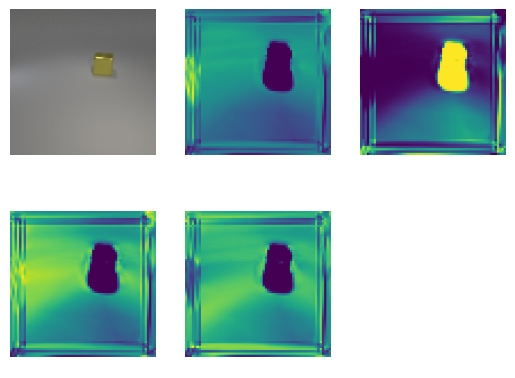

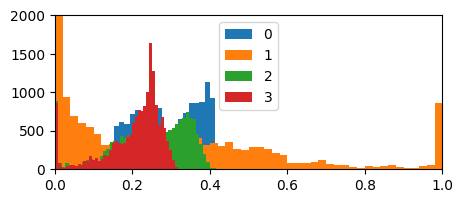

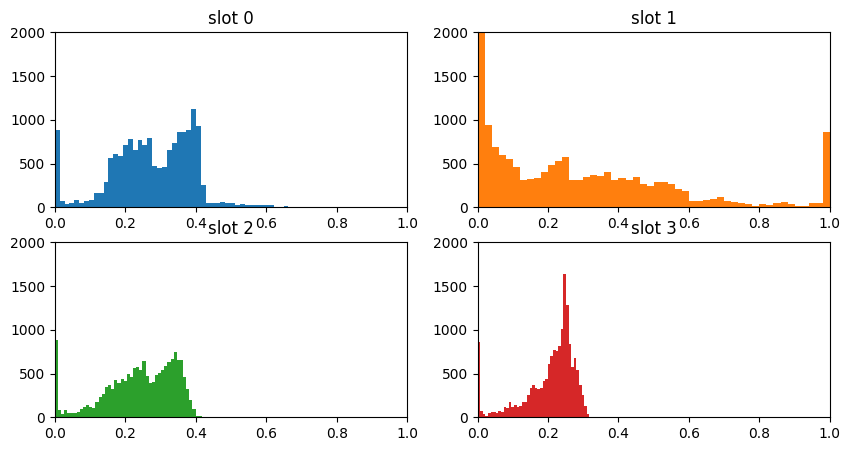

In [86]:
# CLEVR-Easy
# THRESH_ATTN_OBJ_IN_SLOT = 0.98 # found heuristically/visually
# THRESH_COUNT_OBJ_IN_SLOT = 800 # found heuristically/visually
THRESH_OBJ_IN_SLOT = 0.98 # found heuristically/visually
THRESH_ATTN_OBJ_IN_SLOT = 0.98 # found heuristically/visually
THRESH_COUNT_OBJ_IN_SLOT = 500 # found heuristically/visually

img, slots, attns_vis, attns = get_next_sample_and_encs(model, train_loader, args)
# attns1_thresh = thresh_attns(attns1)
plot_img_and_attns(img, attns_vis, attns)
plot_hists(attns)

print([np.sum(attns[i] >= THRESH_OBJ_IN_SLOT) for i in range(args.num_slots)])
obj_slot_ids = find_slot_ids_with_obj(torch.tensor(attns), args)
print(f'Base sample selected slot {obj_slot_ids}')

### Test selecting slot with maximum attention value

Max sample selected slot 2


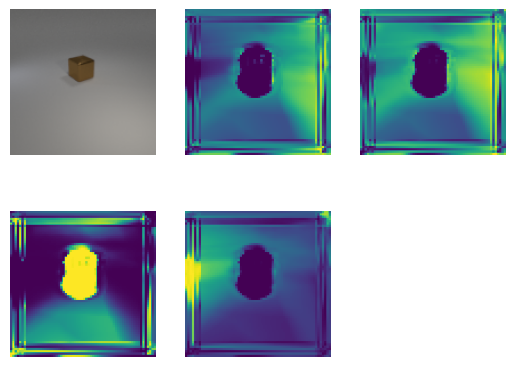

In [88]:
# CLEVR-Easy
# THRESH_ATTN_OBJ_IN_SLOT = 0.98 # found heuristically/visually
# THRESH_COUNT_OBJ_IN_SLOT = 800 # found heuristically/visually
THRESH_OBJ_IN_SLOT = 0.98 # found heuristically/visually
THRESH_ATTN_OBJ_IN_SLOT = 0.98 # found heuristically/visually
THRESH_COUNT_OBJ_IN_SLOT = 500 # found heuristically/visually

img, slots, attns_vis, attns = get_next_sample_and_encs(model, train_loader, args)
plot_img_and_attns(img, attns_vis, attns)

print(f'Max sample selected slot {find_slot_id_max_attn(torch.tensor(attns), args)}')